In [ ]:
# Importing the necessary packages

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [ ]:
# Setting the device to be used as GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Gathering the MNIST data

In [ ]:
#Loading the MNIST dataset

transform = transforms.Compose([transforms.ToTensor()]);

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 84550221.35it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 72406272.46it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22476669.52it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14575767.99it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [ ]:
# Combining the dataset and the sampler and creating an iterator to move over the datasets

train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=False)

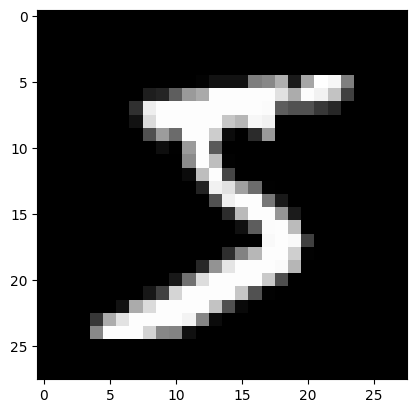

In [ ]:
# Printing the first image from the training data

plt.imshow(train_data.data[0], cmap='gray')
plt.show()

# Building the base CNN callsification model

In [ ]:
# Defining the CNN model for classifying the digits in the MNIST dataset

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    # First convolutional layer
    self.conv_1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size = 2))

    # Second convolutional layer
    self.conv_2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size = 3))

    # Final classification layer with 10 classification classes
    self.fc = nn.Linear(32 * 4 * 4, 10)

  def forward(self,x):
    x = self.conv_1(x)
    x = self.conv_2(x)

    # Flattening the output of the previous layer to the feature size of the last layer
    x = x.view(x.size(0), -1)
    output = self.fc(x)
    return output

model=CNN()

In [ ]:
# Instantiating the model

cnn_model = CNN()
print(cnn_model)

CNN(
  (conv_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
# Setting up the loss function for optimization

loss = nn.CrossEntropyLoss()

In [ ]:
# Setting up the optimizer

optimizer = optim.Adam(cnn_model.parameters(), lr = 0.01)

# Training the base CNN model

In [ ]:
# Defining the training function

def train(num_of_epochs, loss_func, train_loader):

  for epoch in range(num_of_epochs):

    cnn_model.train()
    running_loss = 0.0

    for data in train_loader:

      # Gathering the inputs and labels in this step
      inputs,labels = data

      # Clearing the gradients for each step
      optimizer.zero_grad()

      # Sending the inputs through the model
      outputs = cnn_model(inputs)

      # Running the loss fuction
      loss = loss_func(outputs, labels)

      # Computing the gardients and doing back-propogation
      loss.backward()

      # Applying the gradients by using Adams Optimizer which has enhanced Gradient descent
      optimizer.step()

      # Adding the loss to the total per epoch
      running_loss+=loss.item()

    print(f'Epoch {epoch+1}, Loss:{running_loss/len(train_loader)}')

  print('Finished Training')

In [ ]:
# Starting the training

train(10, loss, train_loader)

Epoch 1, Loss:0.12316251011378666
Epoch 2, Loss:0.0565531836332518
Epoch 3, Loss:0.05735216361480387
Epoch 4, Loss:0.054657744428172596
Epoch 5, Loss:0.050242872799432445
Epoch 6, Loss:0.04561191602991795
Epoch 7, Loss:0.04891477521706973
Epoch 8, Loss:0.04438288422654716
Epoch 9, Loss:0.04938150081148717
Epoch 10, Loss:0.041401750333533466
Finished Training


# Evaluating the base CNN model

In [ ]:
# Evaluating the test time accuracy

cnn_model.eval()
num_correct = 0
num_total = 0

with torch.no_grad():

  for data in test_loader:

    inputs,labels = data

    # Running the inputs through the model
    outputs = cnn_model(inputs)

    # Making the prediction based on highest confidence
    _,predicted=torch.max(outputs.data,1)

    # Updating the counters
    num_total += labels.size(0)
    num_correct += (predicted==labels).sum().item()

print(f'Accuracy on the test dataset:{100 * num_correct / num_total}%')

Accuracy on the test dataset:98.36%


# Generating adversarial examples using iterative FGSM

In [ ]:
# Function to generate adversarial examples using IFGSM
def ifgsm_attack(image, epsilon, data_grad, iterations):

    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    perturbed_image = image

    # Creating the perturbations iteratively
    for i in range(iterations):
        perturbed_image = perturbed_image + epsilon * sign_data_grad
        # Ensure the perturbed image values are within the valid range [0, 1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

# Testing the model on adversarial examples

In [ ]:
def visualize_perturbations(original_image, original_label, perturbed_image, perturbed_label):
    perturbation = perturbed_image - original_image

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image.squeeze().cpu().detach().numpy(), cmap='gray')
    plt.title('Original Image Label - ' + str(original_label.item()))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(perturbation.squeeze().cpu().detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)  # Adjust the colormap if needed
    plt.title('Perturbation')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(perturbed_image.squeeze().cpu().detach().numpy(), cmap='gray')
    plt.title('Perturbed Image Label - ' + str(perturbed_label.item()))
    plt.axis('off')

    plt.show()

In [ ]:
# Function to visualize the original and perturbed images
def visualize_adversarial_examples(original_image, original_label, perturbed_image, perturbed_label):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.squeeze().detach().cpu().numpy(), cmap='gray')
    plt.title('Original Image Label - ' + str(original_label.item()))
    plt.subplot(1, 2, 2)
    plt.imshow(perturbed_image.squeeze().detach().cpu().numpy(), cmap='gray')
    plt.title('Adversarial Example Label - ' + str(perturbed_label.item()))
    plt.show()

In [ ]:
# Function to test the model on adversarial examples
def test_model_on_adversarial(model, loss_func, test_loader, epsilon):
    model.eval()
    correct = 0
    total = 0
    num_of_printed = 0
    iterations = 30

    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad = True  # Enable gradient computation for the input

        outputs = model(inputs)
        loss = loss_func(outputs, labels)

        # Calculate gradients of the loss with respect to the input
        loss.backward()
        data_grad = inputs.grad.data

        # Generate adversarial examples using FGSM
        perturbed_inputs = ifgsm_attack(inputs, epsilon, data_grad, iterations)

        # Evaluate the model on the perturbed inputs
        outputs = model(perturbed_inputs)
        _, predicted = torch.max(outputs, 1)

        # Visualize the original and perturbed images (optional)
        random_image = np.random.randint(15)
        if predicted[random_image] != labels[random_image] and num_of_printed == 0:
            # visualize_adversarial_examples(inputs[random_image], labels[random_image], perturbed_inputs[random_image], predicted[random_image])
            visualize_perturbations(inputs[random_image], labels[random_image], perturbed_inputs[random_image], predicted[random_image])
            num_of_printed += 1

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on the test dataset with epsilon={epsilon}: {accuracy}%')



Testing with epsilon=1e-05


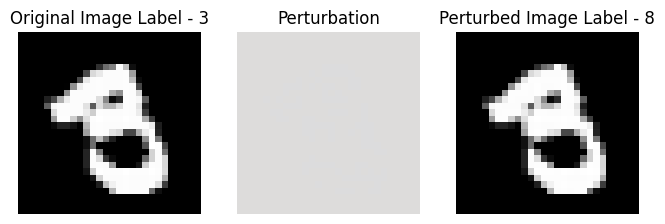

Accuracy on the test dataset with epsilon=1e-05: 98.26%

Testing with epsilon=0.0001


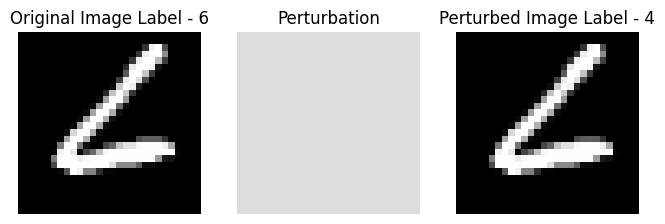

Accuracy on the test dataset with epsilon=0.0001: 97.33%

Testing with epsilon=0.001


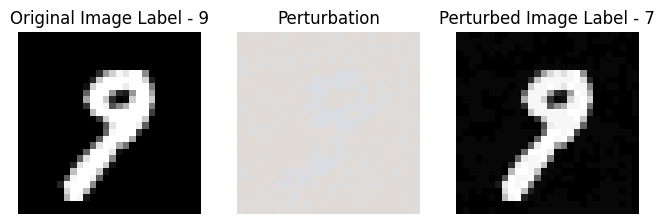

Accuracy on the test dataset with epsilon=0.001: 69.28%

Testing with epsilon=0.01


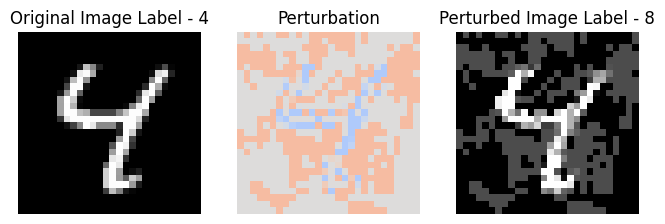

Accuracy on the test dataset with epsilon=0.01: 21.04%

Testing with epsilon=0.05


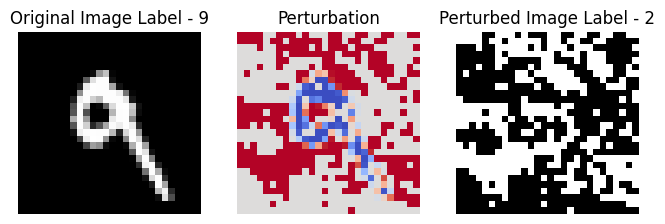

Accuracy on the test dataset with epsilon=0.05: 13.92%

Testing with epsilon=0.1


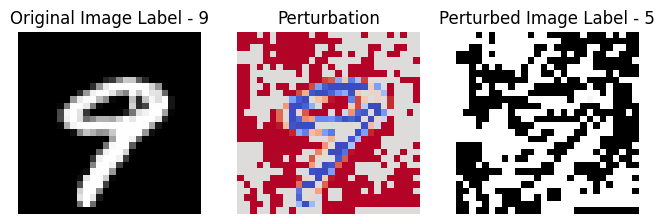

Accuracy on the test dataset with epsilon=0.1: 13.92%

Testing with epsilon=0.15


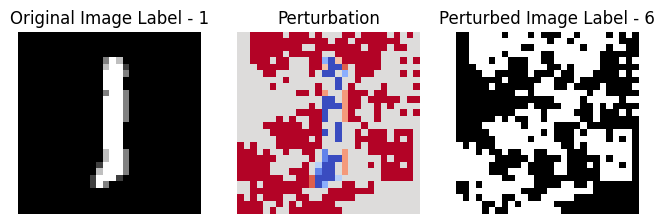

Accuracy on the test dataset with epsilon=0.15: 13.92%

Testing with epsilon=0.2


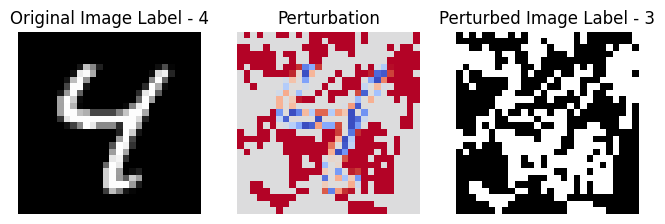

Accuracy on the test dataset with epsilon=0.2: 13.92%

Testing with epsilon=0.25


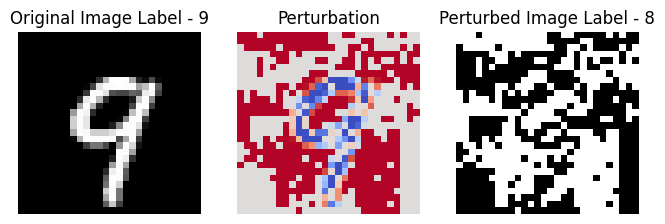

Accuracy on the test dataset with epsilon=0.25: 13.92%


In [ ]:
# Generate and test adversarial examples with different epsilon values
epsilons = [0.00001,0.0001, 0.001,0.01, 0.05, 0.1,0.15,0.2,0.25]

for epsilon in epsilons:
    print(f"\nTesting with epsilon={epsilon}")
    test_model_on_adversarial(cnn_model,loss, test_loader, epsilon)